In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import numpy as np
import xarray as xr
import datetime

# import yaml
import tqdm
import torch
import pickle
import logging
import random

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count

from torch import nn

import torch

import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt

In [3]:
sys.executable

'/glade/u/home/mhayman/miniconda3/envs/ml-torch/bin/python'

In [4]:
# set path to local libraries
dirP_str = '../../../library'
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

import ml_utils as ml
# import ml_defs as mldef

In [5]:
paths = {   'load_data':'/glade/scratch/mhayman/holodec/holodec-ml-data/hist-from-vae/',
            'save_data':'/glade/scratch/mhayman/holodec/holodec-ml-data/hist-from-vae/'}

In [39]:
files = {'data_file': 'training_1_25particles_gamma2D.nc', # _le4 #'histogram_training_data_5000count20200818T100751.nc',# 'histogram_training_data_5000count20200814T075733.nc',     # training data file
        'validation_file':'validation_1_25particles_gamma2D.nc',
        'test_file':'test_1_25particles_gamma2D.nc',}

In [40]:
start_time = datetime.datetime.now()

save_file_base = files['data_file'].replace('.nc','')+'_DecodeNN_'+start_time.strftime('%Y%m%dT%H%M%S')

save_file_path = paths['save_data']+save_file_base+'/'
ml.ensure_path(save_file_path)

In [41]:
print(save_file_base)

training_1_25particles_gamma2D_DecodeNN_20210524T141849


In [42]:
training_ds = xr.open_dataset(paths['load_data']+files['data_file'])
validation_ds = xr.open_dataset(paths['load_data']+files['validation_file'])
training_ds

<xarray.Dataset>
Dimensions:          (d_bin_centers: 40, d_bin_edges: 41, hologram_number: 180000, latent_size: 1014, moments: 4, particle_number: 2028998, rsize: 1200, z_bin_centers: 146, z_bin_edges: 147)
Coordinates:
  * hologram_number  (hologram_number) int64 0 1 2 3 ... 179997 179998 179999
  * d_bin_edges      (d_bin_edges) int64 0 5 10 15 20 25 ... 180 185 190 195 200
  * d_bin_centers    (d_bin_centers) int64 0 5 10 15 20 ... 175 180 185 190 195
  * z_bin_edges      (z_bin_edges) int64 14000 15000 16000 ... 159000 160000
  * z_bin_centers    (z_bin_centers) int64 14000 15000 16000 ... 158000 159000
  * moments          (moments) int64 0 1 2 3
Dimensions without coordinates: latent_size, particle_number, rsize
Data variables: (12/17)
    source_filename  (hologram_number) object ...
    hid              (hologram_number) int64 ...
    raft             (hologram_number, rsize) float32 ...
    mu               (hologram_number, latent_size) float32 ...
    logsig           (hologram_number, latent_size) float32 ...
    z_latent         (hologram_number, latent_size) float32 ...
    ...               ...
    d_hist           (hologram_number, d_bin_centers) int64 ...
    d_hist_lim       (hologram_number, d_bin_centers) int64 ...
    z_hist           (hologram_number, z_bin_centers) int64 ...
    dz_hist          (hologram_number, d_bin_centers, z_bin_centers) float64 ...
    moments_zlim     (hologram_number, moments) float64 ...
    moments_nolim    (hologram_number, moments) float64 ...
Attributes:
    generator:  training_1_25particles_gamma.pkl
    created:    20210427T122019
    zlim_lb:    24000
    zlim_ub:    150000
    d_bin_wid:  5
    d_max:      200
    z_bin_wid:  1000
    z_max:      160000
    z_min:      14000

In [43]:
# generator for VAE decoder

def read_data(filename, in_var, label_var, max_holograms = 1e10):
    """
    data generator for netcdf data
    filename: str
        filename including path to use in generator
    in_var: str
        variable to load from the dataset as an input
    label_var: str
        variable to load as training data
    max_holograms: int
        limit the set size to smaller than what is
        in the data file
    """
    with xr.open_dataset(filename) as ds:
        loaded = 0
        while True:
            try:
                yield torch.tensor(ds[in_var].isel(hologram_number=loaded).values), torch.tensor(ds[label_var].isel(hologram_number=loaded))
                loaded += 1
            except:
                break
            if loaded >= max_holograms:
                break

In [9]:
train_inputs = read_data(paths['load_data']+files['data_file'],'mu','dz_hist')

In [13]:
for in_da in training_inputs:
    print(in_da[0].values[:5])

[ 0.62413687  1.3024302   0.43887284 -0.6221197   0.46862   ]
[ 1.3646911   1.9504323  -2.9565217  -0.07729426 -1.2910931 ]
[-1.7152184  -0.14415681  0.46564174  0.42509437  0.11636823]
[ 0.25206912  0.9759215  -1.4234344   0.03159393 -0.4886579 ]
[-1.3120594  -2.7010288   0.5597257  -0.25498712 -1.700954  ]
[-0.08452333 -1.2303251   1.2030989   0.01935285 -2.692104  ]
[-0.20304959 -0.56243324 -0.67152023  0.52487457 -1.2246764 ]
[ 1.1349989   0.43329823 -0.78056693  1.1977587   0.23079532]
[ 1.4367521  0.6517181 -1.6499256  0.5944417  0.9978596]


In [ ]:
# class HologramDataset(Dataset):
    
#     def __init__(
#         self, 
#         path_data: str, 
#         num_particles: int, 
#         split: str, 
#         subset: bool, 
#         output_cols: List[str], 
#         shuffle: bool = True,
#         scaler: Dict[str, str] = False, 
#         transform = None) -> None:
        
#         'Initialization'
#         self.ds = self.open_dataset(path_data, num_particles, split)
#         self.output_cols = [x for x in output_cols if x != 'hid']        
#         self.subset = subset
#         self.hologram_numbers = self.ds.hologram_number.values
#         self.num_particles = num_particles
#         self.xsize = len(self.ds.xsize.values)
#         self.ysize = len(self.ds.ysize.values)
#         self.shuffle = shuffle
#         self.maxnum_particles = maxnum_particles
#         self.transform = transform
#         self.on_epoch_end()
                
#         if not scaler:
#             self.scaler = {col: StandardScaler() for col in output_cols}
#             for col in output_cols:
#                 scale = self.ds[col].values
#                 self.scaler[col].fit(scale.reshape(scale.shape[-1], -1))
#         else:
#             self.scaler = scaler
            
#         logger.info(
#             f"Loaded {split} hologram data containing {len(self.hologram_numbers)} images"
#         )
        
#     def get_transform(self):
#         return self.scaler

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return len(self.hologram_numbers)
    
#     def __getitem__(self, idx):
#         'Generate one data point'
#         hologram = random.choice(self.hologram_numbers)
#         im = self.ds["image"][hologram].values
#         im = {"image": self.reshape(im)}
#         if self.transform:
#             im = self.transform(im)
#         self.processed += 1
#         if self.processed == self.__len__():
#             self.on_epoch_end()
#         return im["image"]
    
#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.processed = 0
#         if self.shuffle == True:
#             random.shuffle(self.hologram_numbers)
                
#     def reshape(self, X):
#         x, y = X.shape
#         return X.reshape((1,x,y))
            
#     def open_dataset(self, path_data, num_particles, split):
#         """
#         Opens a HOLODEC file

#         Args: 
#             path_data: (str) Path to dataset directory
#             num_particles: (int or str) Number of particles per hologram
#             split: (str) Dataset split of either 'train', 'valid', or 'test'

#         Returns:
#             ds: (xarray Dataset) Opened dataset
#         """
#         path_data = os.path.join(path_data, self.dataset_name(num_particles, split))

#         if not os.path.isfile(path_data):
#             print(f"Data file does not exist at {path_data}. Exiting.")
#             raise 

#         ds = xr.open_dataset(path_data)
#         return ds
    
#     def dataset_name(self, num_particles, split, file_extension='nc'):
#         """
#         Return the dataset filename given user inputs

#         Args: 
#             num_particles: (int or str) Number of particles per hologram
#             split: (str) Dataset split of either 'train', 'valid', or 'test'
#             file_extension: (str) Dataset file extension

#         Returns:
#             ds_name: (str) Dataset name
#         """

#         valid = [1,3,'multi','50-100']
#         if num_particles not in valid:
#             raise ValueError("results: num_particles must be one of %r." % valid)
#         num_particles = num_particles_dict[num_particles]

#         valid = ['train','test','valid']
#         if split not in valid:
#             raise ValueError("results: split must be one of %r." % valid)
#         split = split_dict[split]
#         ds_name = f'synthetic_holograms_{num_particles}_{split}.{file_extension}'

#         return ds_name

In [93]:
# def loss_fn(y_pred, y_actual,l1=0):
#     mse = torch.sum(torch.square(y_pred-y_actual))
#     l1reg = l1*torch.sum(torch.abs(y_pred))
#     loss_out = mse + l1reg
#     return loss_out, mse, l1reg

# class Trainer:
    
#     def __init__(self, 
#                  model, 
#                  optimizer,
#                  train_gen, 
#                  valid_gen, 
#                  dataloader, 
#                  valid_dataloader,
#                  batch_size,
#                  path_save,
#                  device,
#                  l1=0):
        
#         self.model = model
#         self.optimizer = optimizer
#         self.train_gen = train_gen
#         self.valid_gen = valid_gen
#         self.dataloader = dataloader
#         self.valid_dataloader = valid_dataloader
#         self.batch_size = batch_size
#         self.path_save = path_save
#         self.device = device
#         self.test_image = test_image
        
        
#     def train_one_epoch(self, epoch):

#         self.model.train()
#         batches_per_epoch = int(np.ceil(self.train_gen.__len__() / self.batch_size))
#         batch_group_generator = tqdm.tqdm(
#             enumerate(self.dataloader),
#             total=batches_per_epoch, 
#             leave=True
#         )

#         epoch_losses = {"loss": [], "mse": [], "l1reg": []}
#         for idx, images in batch_group_generator:

#             images = images.to(self.device)
#             recon_images, mu, logvar = self.model(images)
            
#             loss,mse,l1reg = loss_fn(y_pred, y_act, l1=l1)

#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()

#             batch_loss = loss.item() / batch_size
#             batch_mse = mse.item() / batch_size
#             batch_l1reg = l1reg.item() / batch_size

#             epoch_losses["loss"].append(batch_loss)
#             epoch_losses["mse"].append(batch_mse)
#             epoch_losses["l1reg"].append(batch_l1reg)

#             loss = np.mean(epoch_losses["loss"])
#             mse = np.mean(epoch_losses["mse"])
#             l1reg = np.mean(epoch_losses["l1reg"])

#             to_print = "loss: {:.3f} mse: {:.3f} l1reg: {:.3f}".format(loss, mse, l1reg)
#             batch_group_generator.set_description(to_print)
#             batch_group_generator.update()

#         return loss, mse, l1reg


#     def test(self, epoch):

#         self.model.eval()
#         batches_per_epoch = int(np.ceil(self.valid_gen.__len__() / self.batch_size))

#         with torch.no_grad():

#             batch_group_generator = tqdm.tqdm(
#                 enumerate(self.valid_dataloader),
#                 total=batches_per_epoch, 
#                 leave=True
#             )

#             epoch_losses = {"loss": [], "mse": [], "l1reg": []}
#             for idx, images in batch_group_generator:

#                 images = images.to(self.device)
#                 recon_images, mu, logvar = self.model(images)
#                 loss,mse,l1reg = loss_fn(y_pred, y_act, l1=l1)

#                 batch_loss = loss.item() / batch_size
#                 batch_mse = mse.item() / batch_size
#                 batch_l1reg = l1reg.item() / batch_size

#                 epoch_losses["loss"].append(batch_loss)
#                 epoch_losses["mse"].append(batch_mse)
#                 epoch_losses["l1reg"].append(batch_l1reg)

#                 loss = np.mean(epoch_losses["loss"])
#                 mse = np.mean(epoch_losses["mse"])
#                 l1reg = np.mean(epoch_losses["l1reg"])

#                 to_print = "loss: {:.3f} mse: {:.3f} l1reg: {:.3f}".format(loss, mse, l1reg)
#                 batch_group_generator.set_description(to_print)
#                 batch_group_generator.update()

#         return loss

In [10]:
### setup the data logger

root = logging.getLogger()
root.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')

# Stream output to stdout
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
root.addHandler(ch)

# Save the log file
logger_name = os.path.join(save_file_path, save_file_path, "log.txt")
fh = logging.FileHandler(logger_name,
                         mode="w",
                         encoding='utf-8')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
root.addHandler(fh)

###

In [44]:
# def loss_fn(y_pred, y_actual,l1=0):
#     mse = ((y_pred-y_actual)**2).mean()
#     l1reg = l1*((y_pred).abs()).mean()
#     loss_out = mse + l1reg
#     return loss_out #, mse, l1reg

def loss_fn(y_pred, y_actual,l1=0):
    mse = ((y_pred.cumsum(1).cumsum(2)-y_actual.cumsum(1).cumsum(2))**2).mean()
    l1reg = l1*((y_pred).abs()).mean()
    loss_out = mse + l1reg
    return loss_out #, mse, l1reg

# loss_fn = F.binary_cross_entropy
# loss_fn = F.mse_loss

In [45]:
### Use gpu if available
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
    
logging.info(f'Preparing to use device {device}')
### 

In [46]:
### Program Inputs

# number of nodes in each dense layer except the last one
# the size of the last layer is determined by the output
# size
layer_nodes = [4000, 2000, 1000]# [1000,800]  
epochs = 60
learning_rate = 1e-4
optimizer_type = 'adam'
batch_size = 128
workers = 1
in_var = 'mu'
label_var = 'dz_hist'
###



In [47]:
is_cuda

True

In [48]:
is_cuda

True

In [49]:
input_size = np.prod(training_ds['mu'].shape[1:])
# output_size = np.prod(training_ds['dz_hist'].shape[1:])
output_shape = training_ds['dz_hist'].shape[1:]

class LatentDecoder(nn.Module):
    def __init__(self,in_size,out_shape,layer_nodes):
        """
        in_size: int
            size of inputs tensor
        out_shape: tuple
            shape of the output tensor
        """
        super(LatentDecoder, self).__init__()
        
        self.out_shape = out_shape
        out_size = np.prod(out_shape)

        # create a list of the NN layers
        self.layer_lst = nn.ModuleList()
        for idx,node_count in enumerate(layer_nodes):
            if idx == 0:
                self.layer_lst.append(nn.Linear(in_size,node_count))
            else:
                self.layer_lst.append(nn.Linear(layer_nodes[idx-1],node_count))
            
        self.layer_lst.append(nn.Linear(layer_nodes[-1],out_size))
        
        self.activation = nn.ReLU()
        self.output_activation = nn.ReLU() #nn.Sigmoid()
 
    def forward(self, x):
        in_shape = x.shape
        x = nn.Flatten()(x)
        for layer in self.layer_lst[:-1]:
            x = self.activation(layer(x))
        output = self.output_activation(self.layer_lst[-1](x)).reshape((in_shape[0],)+self.out_shape)
#         output = nn.Unflatten(1, output_shape)(self.output_activation(self.layer_lst[-1](x)))

        return output

In [50]:
decode_model = LatentDecoder(input_size,output_shape,layer_nodes)

In [51]:
decode_model.to(device)

LatentDecoder(
  (layer_lst): ModuleList(
    (0): Linear(in_features=1014, out_features=4000, bias=True)
    (1): Linear(in_features=4000, out_features=2000, bias=True)
    (2): Linear(in_features=2000, out_features=1000, bias=True)
    (3): Linear(in_features=1000, out_features=5840, bias=True)
  )
  (activation): ReLU()
  (output_activation): ReLU()
)

In [52]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(decode_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(decode_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )
#     sys.exit(1)

In [53]:
# logging.info(f"Loading training data iterator using {workers} workers")
    
# dataloader = DataLoader(
#     train_gen,
#     batch_size = batch_size,
#     shuffle = True,
#     num_workers = workers
# )

# valid_dataloader = DataLoader(
#     valid_gen,
#     batch_size = batch_size,
#     shuffle = False,
#     num_workers = workers
# )

In [54]:
train_ds = TensorDataset(torch.tensor(training_ds[in_var].values).float().to(device), torch.tensor(training_ds[label_var].values).float().to(device))
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(torch.tensor(validation_ds[in_var].values).float().to(device), torch.tensor(validation_ds[label_var].values).float().to(device))
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [55]:
reg_coef = 0.5

In [56]:
batches_per_epoch = len(train_dl)
train_loss_hist = []
valid_loss_hist = []

for epoch in range(epochs):
    train_loss = 0
    decode_model.train()
    for batch_idx,(xb,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch,leave=True):
#         pred = decode_model(xb.float().to(device))
#         loss = loss_fn(pred, yb.float().to(device))
        pred = decode_model(xb)
        loss = loss_fn(pred, yb, l1=reg_coef)
        train_loss += loss.sum().to('cpu').item()
#         train_loss+=loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    decode_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(decode_model(xb), yb, l1=0) for xb, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss / len(train_dl), valid_loss.item() / len(valid_dl))

  1%|▏         | 21/1407 [00:00<00:06, 201.04it/s]

0 7.283458898824923 6.9408183037480224


  1%|▏         | 21/1407 [00:00<00:06, 201.57it/s]

1 4.634672212194024 6.656273950504351


  1%|▏         | 20/1407 [00:00<00:06, 199.99it/s]

2 3.854808163287035 6.658926275712025


  1%|▏         | 21/1407 [00:00<00:06, 201.71it/s]

3 3.02847506903382 7.2343309619758704


  1%|▏         | 20/1407 [00:00<00:07, 195.51it/s]

4 2.3965852480876846 7.624949781200554


  1%|▏         | 20/1407 [00:00<00:07, 197.28it/s]

5 1.9506157369755988 7.3317986983287184


  1%|▏         | 21/1407 [00:00<00:06, 200.53it/s]

6 1.6696559726217577 7.496901886372626


  3%|▎         | 41/1407 [00:00<00:06, 205.25it/s]

7 1.4936445344824612 7.576335665545886


  1%|▏         | 21/1407 [00:00<00:06, 201.91it/s]

8 1.353793779246419 7.260885117929193


  1%|▏         | 20/1407 [00:00<00:06, 199.96it/s]

9 1.2347844222291786 7.406416880933544


  1%|▏         | 20/1407 [00:00<00:06, 198.95it/s]

10 1.1405256075391383 7.258320868769778


  1%|▏         | 21/1407 [00:00<00:06, 200.83it/s]

11 1.071991991344376 7.4643168389042724


  1%|▏         | 20/1407 [00:00<00:06, 199.52it/s]

12 1.0077513631303512 7.273065880884098


  1%|▏         | 20/1407 [00:00<00:06, 199.31it/s]

13 0.9434455942836483 7.5164285007911396


  1%|▏         | 21/1407 [00:00<00:06, 200.50it/s]

14 0.8972607456629549 7.1419955869264244


  1%|▏         | 20/1407 [00:00<00:06, 198.94it/s]

15 0.8576652066624579 7.135781589942642


  1%|▏         | 21/1407 [00:00<00:06, 201.34it/s]

16 0.8138335994904823 7.293792338310918


  1%|▏         | 21/1407 [00:00<00:06, 201.28it/s]

17 0.7840553343762043 7.175839967365507


  1%|▏         | 21/1407 [00:00<00:06, 201.53it/s]

18 0.7555187370816104 7.0601134481309336


  1%|▏         | 20/1407 [00:00<00:06, 198.69it/s]

19 0.7253350098250009 7.247439613825159


  1%|▏         | 21/1407 [00:00<00:06, 201.52it/s]

20 0.6961486376848471 7.202793555923655


  1%|▏         | 21/1407 [00:00<00:06, 202.02it/s]

21 0.6724085929381907 7.1280417140526104


  1%|▏         | 21/1407 [00:00<00:06, 201.57it/s]

22 0.6514472683948579 7.110594157931171


  1%|▏         | 21/1407 [00:00<00:06, 202.20it/s]

23 0.6340678357535757 7.2350687920292724


  1%|▏         | 21/1407 [00:00<00:06, 200.33it/s]

24 0.6141249195387284 7.209307320510285


  1%|▏         | 21/1407 [00:00<00:06, 201.92it/s]

25 0.5932205985138073 7.17809208737144


  1%|▏         | 21/1407 [00:00<00:06, 201.34it/s]

26 0.578089207580264 7.128039396261867


  1%|▏         | 21/1407 [00:00<00:06, 201.49it/s]

27 0.5672888810658336 7.211518492879747


  1%|          | 14/1407 [00:00<00:11, 120.16it/s]

28 0.5540493286367673 7.148292251780063


  1%|▏         | 21/1407 [00:00<00:06, 202.20it/s]

29 0.5405993588909496 7.131288938884493


  1%|▏         | 21/1407 [00:00<00:06, 201.74it/s]

30 0.5280648008380787 7.205234189576741


  1%|▏         | 21/1407 [00:00<00:06, 202.19it/s]

31 0.5146762740340908 7.142137744758703


  1%|▏         | 21/1407 [00:00<00:06, 200.79it/s]

32 0.5038697467090902 7.24227403085443


  1%|▏         | 21/1407 [00:00<00:06, 201.52it/s]

33 0.49599531322569396 7.275991705399525


  1%|▏         | 21/1407 [00:00<00:06, 202.43it/s]

34 0.4827894398356128 7.1439255340189876


  1%|▏         | 21/1407 [00:00<00:06, 201.76it/s]

35 0.4761437615690794 7.326656293265427


  1%|▏         | 21/1407 [00:00<00:06, 202.64it/s]

36 0.46643856385962373 7.332229034810126


  1%|▏         | 21/1407 [00:00<00:06, 201.04it/s]

37 0.4572905736903222 7.145245129549051


  1%|▏         | 20/1407 [00:00<00:06, 199.95it/s]

38 0.4517017361240007 7.224035335492484


  1%|▏         | 21/1407 [00:00<00:06, 202.23it/s]

39 0.4464903081573318 7.3076828582377376


  1%|▏         | 21/1407 [00:00<00:06, 202.62it/s]

40 0.4384879825931961 7.207916646064082


  1%|▏         | 20/1407 [00:00<00:06, 199.30it/s]

41 0.4285764267407331 7.293643227106409


  1%|▏         | 21/1407 [00:00<00:06, 202.68it/s]

42 0.421579375873666 7.247825912282437


  1%|▏         | 21/1407 [00:00<00:06, 202.54it/s]

43 0.4148556040209409 7.3292066356803796


  1%|▏         | 21/1407 [00:00<00:06, 202.59it/s]

44 0.41474447685857146 7.139096030706091


  1%|▏         | 21/1407 [00:00<00:06, 201.82it/s]

45 0.4078865242326353 7.46157334726068


  1%|          | 15/1407 [00:00<00:09, 144.56it/s]

46 0.40676556221542415 7.258210387410997


  1%|▏         | 21/1407 [00:00<00:06, 202.65it/s]

47 0.39289615172482417 7.139778233781645


  1%|▏         | 21/1407 [00:00<00:06, 202.75it/s]

48 0.38716062835623544 7.3255715671973896


  1%|▏         | 21/1407 [00:00<00:06, 202.13it/s]

49 0.38713268936739464 7.32829960690269


  1%|▏         | 21/1407 [00:00<00:06, 200.74it/s]

50 0.38546946704091123 7.1600728095332276


  1%|▏         | 21/1407 [00:00<00:06, 203.42it/s]

51 0.3781941718002881 7.43914794921875


  1%|▏         | 21/1407 [00:00<00:06, 202.95it/s]

52 0.3791517529321547 7.4283547703223896


  1%|▏         | 21/1407 [00:00<00:06, 203.31it/s]

53 0.3745838760609481 7.406162696548655


  1%|▏         | 21/1407 [00:00<00:06, 200.82it/s]

54 0.36248467696331543 7.221090196054193


  1%|▏         | 21/1407 [00:00<00:06, 202.94it/s]

55 0.35307832247582244 7.493010315714003


  1%|▏         | 21/1407 [00:00<00:06, 203.54it/s]

56 0.3597147338298846 7.353884926325159


  1%|▏         | 21/1407 [00:00<00:06, 203.41it/s]

57 0.3711825761925522 7.429101098941851


  1%|▏         | 21/1407 [00:00<00:06, 203.45it/s]

58 0.35363819678370295 7.492236173605617


100%|██████████| 1407/1407 [00:06<00:00, 210.08it/s]


59 0.3403423586125567 7.454923605617089


In [1]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

NameError: name 'plt' is not defined

In [57]:
valid_sets = []
with torch.no_grad():
    for xv, yv in valid_dl:
        valid_sets.append([decode_model(xv), yv])

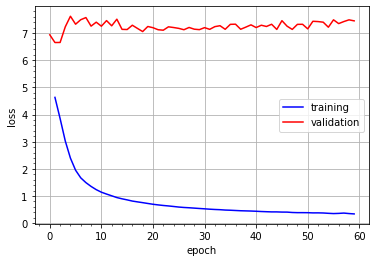

In [58]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

Text(0, 0.5, 'diameter [$\\mu m$]')

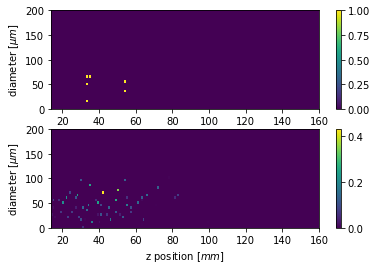

In [59]:
idx = 17
fig,ax = plt.subplots(2,1)
im1=ax[0].pcolormesh(validation_ds['z_bin_edges']*1e-3,validation_ds['d_bin_edges'],yb[idx,:,:].cpu().detach().numpy())
plt.colorbar(im1,ax=ax[0])
ax[0].set_ylabel('diameter [$\mu m$]')
im2 = ax[1].pcolormesh(validation_ds['z_bin_edges']*1e-3,validation_ds['d_bin_edges'],decode_model(xb).cpu().detach().numpy()[idx,:,:])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel('z position [$mm$]')
ax[1].set_ylabel('diameter [$\mu m$]')

Text(0, 0.5, 'diameter [$\\mu m$]')

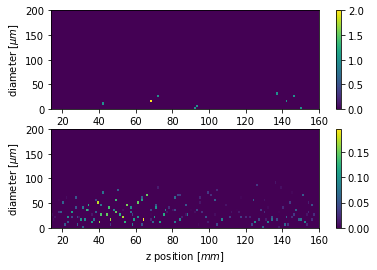

In [60]:
idx=1
fig,ax = plt.subplots(2,1)
im1=ax[0].pcolormesh(validation_ds['z_bin_edges']*1e-3,validation_ds['d_bin_edges'],valid_sets[idx][1][0,:,:].cpu().detach().numpy())
plt.colorbar(im1,ax=ax[0])
ax[0].set_ylabel('diameter [$\mu m$]')
im2 = ax[1].pcolormesh(validation_ds['z_bin_edges']*1e-3,validation_ds['d_bin_edges'],valid_sets[idx][0].cpu().detach().numpy()[idx,:,:])
plt.colorbar(im2,ax=ax[1])
ax[1].set_xlabel('z position [$mm$]')
ax[1].set_ylabel('diameter [$\mu m$]')

In [33]:
len(valid_sets)

16

In [ ]:
for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        end_i = start_i + bs
        start_i = i * bs
#         xb = x_train[start_i:end_i]
#         yb = y_train[start_i:end_i]
        x = torch.tensor(training_ds[in_var].isel(hologram_number=slice(start_i,end_i)).values)
        y = torch.tensor(training_ds[label_var].isel(hologram_number=slice(start_i,end_i)).values)
        
        pred = model(xb)
        loss = loss_fn(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
            model.zero_grad()

In [ ]:
### Training Loop

logging.info(
    f"Training the model for up to {epochs} epochs"
)

for epoch in range(start_epoch, epochs):
    

#     train_loss, train_bce, train_kld = trainer.train_one_epoch(epoch)
#     test_loss, test_bce, test_kld = trainer.test(epoch)

#     scheduler.step(test_loss)
#     early_stopping(epoch, test_loss, trainer.model, trainer.optimizer)

#     # Write results to the callback logger 
#     result = {
#         "epoch": epoch,
#         "train_loss": train_loss,
#         "train_bce": train_bce,
#         "train_kld": train_kld,
#         "valid_loss": test_loss,
#         "valid_bce": test_bce,
#         "valid_kld": test_kld,
#         "lr": early_stopping.print_learning_rate(trainer.optimizer)
#     }
#     metrics_logger.update(result)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break